In [1]:
using PyPlot, LinearAlgebra, ImageFiltering, JLD2, MATLAB, MAT

include("code/acoustic_solver.jl")
include("code/acoustic_solver_parallel.jl")
include("code/adjoint_method_new.jl")
include("code/Gauss_Newton.jl")
include("code/TV_projection.jl")
include("code/TV_function.jl")


grad_tv (generic function with 1 method)

In [63]:
# load data
file = matopen("marmousi_data/marmousi_vp10.mat")
vp10 = read(file, "marmousi_vp10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

Nx = 69
Ny = 301
ratio = 5
h = 10*1e-3 * ratio

c_true = vp10[1:ratio:1+(Nx-1)*ratio, 1:ratio:(Ny-1)*ratio+1]
# c_true = ones(Nx, Ny)
# c_true[30:45,30:45] .= 1.2
# c_true[30:35,:] .= 1.1
# c_true[50:60,:] .= 1.15

# c_cut = ones(Nx, Ny)

# gaussian filter to generate the initial model
c = imfilter(c_true, Kernel.gaussian(10));
c = (c .- minimum(c)) ./ (maximum(c)-minimum(c)) * (maximum(c_true)-minimum(c_true)) .+ minimum(c_true);
# c[1:16, :] .= 1.5
rho = ones(Nx,Ny);
# rho[40:60,30:40] .= 1.5

delta_c = c_true - c;

In [64]:
size(c_true)

(69, 301)

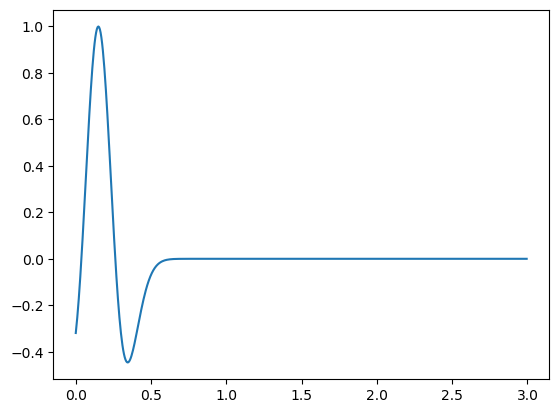

CFL: 0.4699999809265136


In [84]:
# setup coef
Nt = 600
Fs = 200
dt = 1 / Fs
t = range(0, step=dt, length=Nt)
println("CFL: ", maximum(c_true) * dt / h);

# source
source = source_ricker(2,0.15,t)
source_num = 6
source_position = zeros(Int,source_num,2)
for i = 1:source_num
    source_position[i,:] = [5 1+40(i-1)]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 51
receiver_position = zeros(Int,receiver_num,2)
for i = 1:51
    receiver_position[i,:] = [1, (i-1)*5+1]
end
# for i = 52:101
#     receiver_position[i,:] = [61, (i-51)*2+1]
# end
# for i = 102:131
#     receiver_position[i,:] = [(i-102)*2+1, 1]
# end
# for i = 132:161
#     receiver_position[i,:] = [(i-132)*2+1, 101]
# end

# PML
pml_len = 30
pml_coef = 50;

plot(t,source);

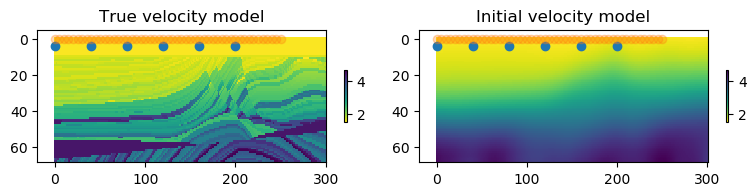

In [85]:
# plot model
figure(figsize=(8,4))

subplot(221)
imshow(c_true, cmap="viridis_r", aspect=2); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(222)
imshow(c, cmap="viridis_r", aspect=2); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [86]:
@time received_data = multi_solver_no_wavefield(c_true, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);


  3.802690 seconds (300.37 k allocations: 61.157 MiB)


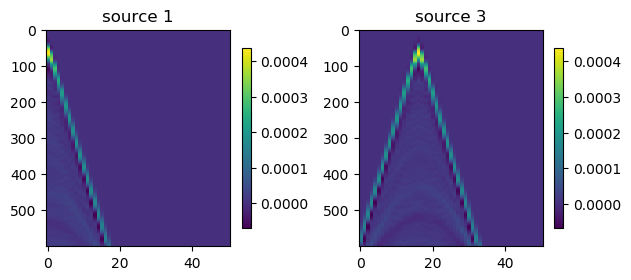

In [87]:

subplot(121)
source_ind = 1
imshow(received_data[:,:,source_ind], aspect=0.1); title("source 1"); colorbar(shrink=0.4)
subplot(122)
source_ind = 3
imshow(received_data[:,:,source_ind], aspect=0.1); title("source 3"); colorbar(shrink=0.4)
tight_layout()

In [7]:
# function handle
CG_tol = 0.2
CG_iterMax = 15

eval_fn(x) = compute_obj_fn(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)


eval_grad(x) = compute_grad(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)


eval_CG_step(x) = compute_CG_step(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; CG_tol=CG_tol, CG_iterMax=CG_iterMax, pml_len=30, pml_coef=50);


In [8]:
fk, gg = eval_grad(c);
fk1, gg1 = eval_CG_step(c);

    Start CG iteration. ||grad f|| = 5.23486e-12, tol = 1.04697e-12
    iteration: 1, ||r1|| = 3.22056e-12
    iteration: 2, ||r1|| = 2.82722e-12
    iteration: 3, ||r1|| = 1.34074e-12
    iteration: 4, ||r1|| = 8.81240e-13 < tol, break
    CG iteration done.


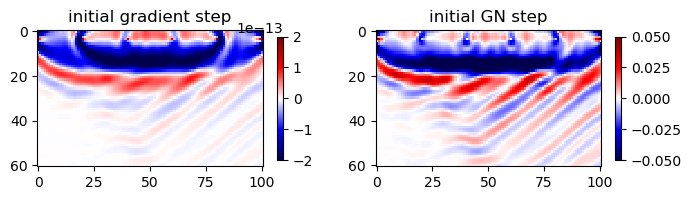

PyObject Text(0.5, 1, 'initial GN step')

In [9]:
figure(figsize=(8,4))
subplot(121)
va = 2e-13
imshow(reshape(-gg, Nx, Ny), cmap="seismic"); colorbar(shrink=0.4); clim(-va, va); title("initial gradient step")
subplot(122)
va = 5e-2
imshow(reshape(gg1, Nx, Ny), cmap="seismic"); colorbar(shrink=0.4); clim(-va, va); title("initial GN step")

In [10]:
x0 = copy(c)
iterNum = 10
min_value = 0
max_value = 100

xk, fk = Gauss_Newton(eval_fn, eval_CG_step, x0, iterNum, min_value, max_value; alpha=1, rho=0.5, c=1e-20, maxSearchTime=3, threshold=1e-12);





----------------------------------------------------------------
Start Gauss Newton method:
----------------------------------------------------------------
    Start CG iteration. ||grad f|| = 5.23486e-12, tol = 1.04697e-12
    iteration: 1, ||r1|| = 3.22056e-12
    iteration: 2, ||r1|| = 2.82722e-12
    iteration: 3, ||r1|| = 1.34074e-12
    iteration: 4, ||r1|| = 8.81240e-13 < tol, break
    CG iteration done.
----------------------------------------------------------------
Main iteration: 1
Start line search. fk: 1.63845e-09
    alpha: 1.00000e+00    fk1: 5.59781e-10    fk-c*alpha*gradk^2: 1.63845e-09
Line search succeed. Search time: 0.
----------------------------------------------------------------
    Start CG iteration. ||grad f|| = 3.58807e-12, tol = 7.17615e-13
    iteration: 1, ||r1|| = 2.58659e-12
    iteration: 2, ||r1|| = 1.08133e-12
    iteration: 3, ||r1|| = 6.34375e-13 < tol, break
    CG iteration done.
----------------------------------------------------------------

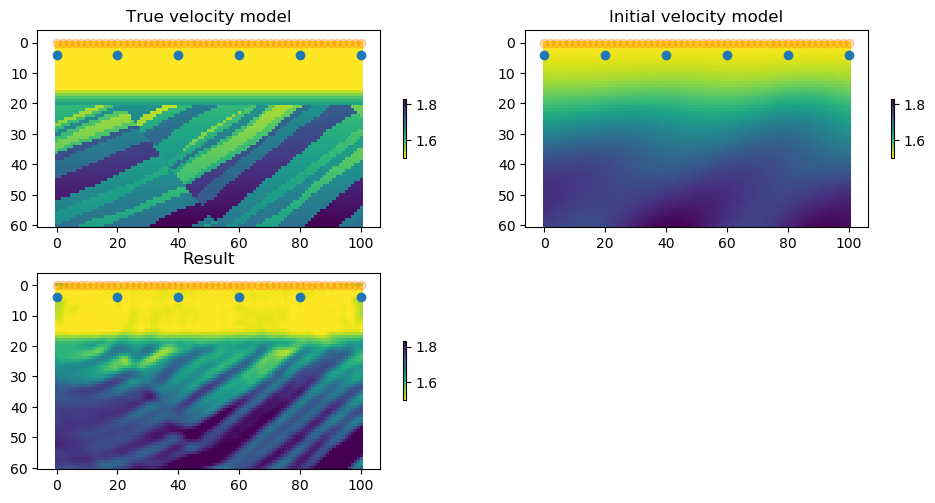

In [12]:
# plot model
ma = maximum(c_true)
mi = minimum(c_true)
figure(figsize=(10,5))

subplot(221)
imshow(c_true, cmap="viridis_r"); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(222)
imshow(c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(223)
imshow(reshape(xk,Nx,Ny), cmap="viridis_r"); title("Result"); colorbar(shrink=0.3); clim(mi, ma)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [14]:
@save "data_gn.jld2" c c_true xk